The temperature in the bottom of the Salish Sea for nowcast-green is much too cold. Can this impact the density and in turn the deep water renewal?

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from dateutil import tz

from salishsea_tools import (
    geo_tools,
    viz_tools,
    places,
    psu_tools,
    teos_tools,
    tidetools,
)

from nowcast import analyze

%matplotlib inline

In [9]:
grid_B=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_downonegrid.nc')
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone.nc')

In [10]:
t_o=datetime.datetime(2015,12,5); t_f = datetime.datetime(2016,7,3)
sdt=t_o.replace(tzinfo=tz.tzutc()); edt=t_f.replace(tzinfo=tz.tzutc())

fnames = analyze.get_filenames(t_o, t_f, '1d', 'grid_T', '/results/SalishSea/nowcast-green/')

In [11]:
def get_density_time_series(station, fnames, grid_B, mesh_mask, nemo_36=True):
    """Retrieve the density time series at a axes in the axes. 
    Time series is created from files listed in fnames"""
    if nemo_36:
        depth_var='gdept_0'
    else:
        depth_var='gdept'
    
    #station info
    lon = places.PLACES[station]['lon lat'][0]
    lat = places.PLACES[station]['lon lat'][1]
    depth = places.PLACES[station]['depth']
    
    # model corresponding locations
    bathy, X, Y = tidetools.get_bathy_data(grid_B)
    j, i = geo_tools.find_closest_model_point(lon,lat,X,Y, land_mask=bathy.mask)
    model_depths = mesh_mask.variables[depth_var][0,:,j,i]
    k = tidetools.find_model_level(depth, model_depths)
    print (model_depths[k], depth)

    sal, time = analyze.combine_files(fnames,'vosaline',k,j,i) #consider interpolating ?
    temp, time = analyze.combine_files(fnames,'votemper',k,j,i) #consider interpolating ?
    
    if nemo_36:
        sal = teos_tools.teos_psu(sal)
    
    density = psu_tools.calculate_density(temp, sal)
    
    return density, sal, temp, time

In [12]:
rhos = {}
times = {}
sals={}
temps={}

station= 'Central node'
rhos[station],sals[station], temps[station], times[station] = get_density_time_series(station, fnames,
                                                                                      grid_B, mesh_mask)

306.834 300


In [13]:
station= 'East node'
rhos[station],sals[station], temps[station], times[station] = get_density_time_series(station, fnames,
                                                                                      grid_B, mesh_mask)

173.114 170


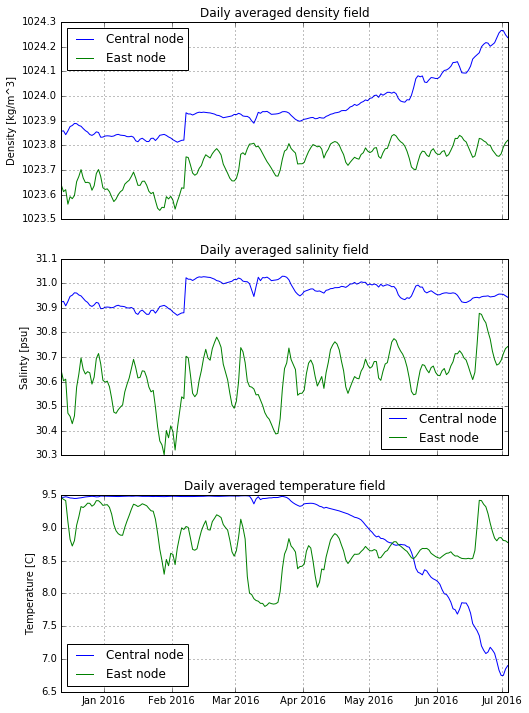

In [14]:
fig, axs = plt.subplots(3,1,figsize=(8,12), sharex=True)
variables = [rhos, sals, temps]
names = ['Density [kg/m^3]', 'Salinty [psu]', 'Temperature [C]']
titles = ['density', 'salinity', 'temperature']
for var, name, title, ax in zip(variables, names, titles, axs):
    for station in ['Central node', 'East node']:
        ax.plot(times[station], var[station], label=station)
        ax.set_ylabel(name)
    ax.grid()
    ax.legend(loc=0)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.set_title('Daily averaged {} field'.format(title))

** East renewal event in late June**
* Why did the temperature increasing? Summer renewals typically bring in colder water. Could it be related to boundary conditions at JDF? I modified salinity but not temperature, although I believe there was a warm bias in June:
http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Nancy/strat/comparisons/JuandeFucaBCs.ipynb ONC plotting utility shows that East temperature didn't change much during this renewal.
* As a result, the density at the East node is not high enough for a renewal. 
* Even so, the cold temperature at Central is making the density so high that I doubt we will renew this summer. A quick look at ONC State of the ocean plots suggests that observed density spikes at East node are typically less than .5 kg/m^3 during renweal events. http://www.oceannetworks.ca/in%C2%ADstal%C2%ADla%C2%ADtions/observatories/salish-sea/eastern-strait-georgia#SOO-SG-East